# Random Forest

This notebook applies a random forest classifier to the homeowner dataset. Random forests are ensemble models that combine multiple decision trees to improve predictive accuracy and reduce overfitting. They are well-suited for handling non-linear relationships and provide robust performance out of the box.

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
df = pd.read_excel('combined_data_binary.xlsx', index_col=0)

In [12]:
# Separate features and target variable
X = df.drop('booked_energy_consultation', axis=1)
y = df['booked_energy_consultation']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# One-hot encode the categorical variables
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(X[categorical_cols])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([X[numerical_cols].reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)

#### Splitting the data into test and training set, training set 70%, test set 30%

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Standardizing the DataFrame

In [14]:
# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initializing Random Forest

In [15]:
# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

### Making predictions

In [16]:
# Make predictions
y_pred = random_forest.predict(X_test_scaled)

class_labels = random_forest.classes_
f1 = f1_score(y_test, y_pred, average=None)
precision = precision_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

# Evaluate the model
print("Classification Report Random Forest:")
print(classification_report(y_test, y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}", )

Classification Report Random Forest:
              precision    recall  f1-score   support

       False       0.90      0.99      0.94      1474
        True       0.98      0.79      0.88       776

    accuracy                           0.92      2250
   macro avg       0.94      0.89      0.91      2250
weighted avg       0.93      0.92      0.92      2250

Accuracy Score: 0.92


The random forest model achieved an overall accuracy of 92%. It demonstrated excellent precision across both classes, especially for the positive class ("True") with a precision of 98%. However, the recall for the positive class was lower at 79%, indicating that while most predicted positives are correct, the model misses some truly interested homeowners. This trade-off suggests that the model is conservative in its positive predictions, prioritizing confidence over completeness. Overall, the model performs strongly and could be valuable in scenarios where minimizing false positives is more important than capturing all potential leads, such as in the creation of complete lead lists.

### Ranking Feature Importance

In addition to model evaluation, this notebook was also used to visualize feature importance. Understanding which features contribute most to the model’s predictions provides important insights into what drives a homeowner’s decision to book an energy consultation. This not only helps with model interpretability but also supports strategic decision-making. For example: identifying which customer attributes should be prioritized in marketing or outreach campaigns.

In [17]:
feature_importances = pd.DataFrame(random_forest.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                                     importance
investment_willingness                 0.116210
knowledge_energy                       0.114861
income                                 0.110512
house_size                             0.093820
energy_awareness                       0.087751
age                                    0.068586
household_size                         0.068475
energy_source_Renewable sources        0.066760
house_age                              0.063322
energy_source_Non-renewable sources    0.045431
energy_bill                            0.044673
perceived_efficiency                   0.023928
attitude_energy_reduction              0.015594
environment_concern                    0.014533
previous_renovations                   0.011313
gender_Male                            0.010376
gender_Female                          0.006170
occupation_status_Employed             0.005185
belief_climate_change_No               0.003969
financial_awareness_Yes                0

### Visualizing the Importance

In [18]:
importances = random_forest.feature_importances_
feature_names = X_train.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

In [19]:
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

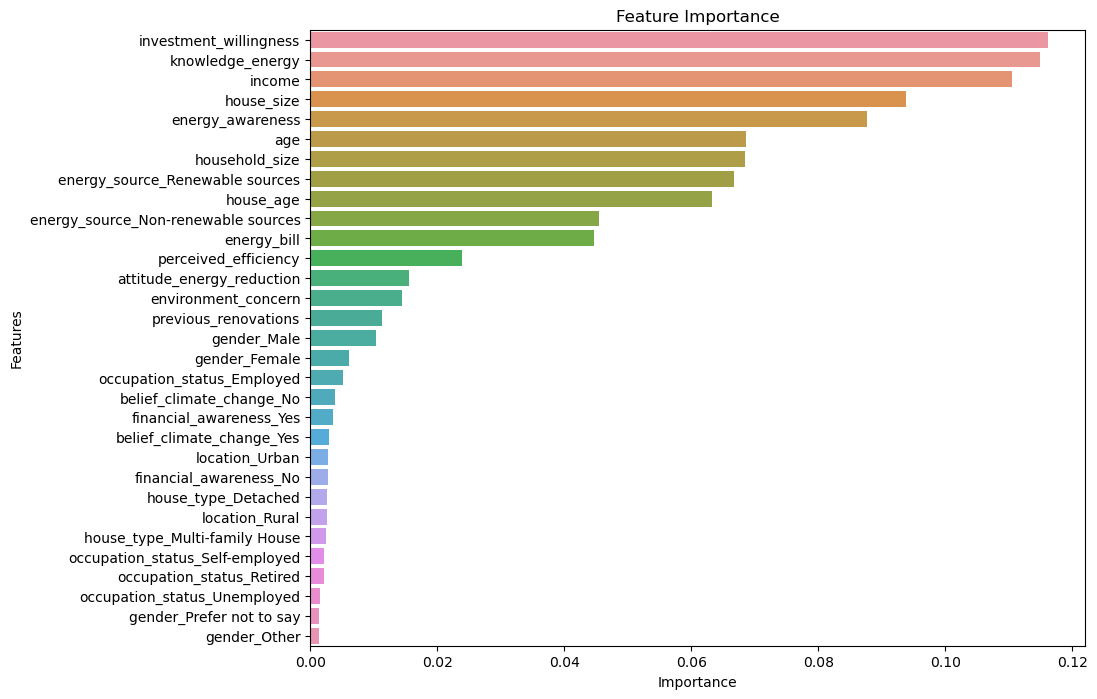

In [20]:
plt.figure(figsize=(10, 8))  # Set the figure size (width, height)
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### Saving Model

As this model performed best (achieved the highest precision score for "True"), it was decided to use for the final identification of homeowners from the new lead list (Potential_Customers.xlsx).

In [13]:
joblib.dump(random_forest, 'random_forest_model.pkl')